In [8]:
import time
startTime=time.time()

input_shape=(256, 256, 3)

from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                    include_top= False, # When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).
                    #input_shape=(150, 150, 3),
                    input_shape=input_shape, 
                    ) 
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [9]:
#import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir='.\\dataset\\train'
validation_dir='.\\dataset\\validation'
test_dir='.\\dataset\\test'
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 54
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                                            directory,
                                            target_size=(input_shape[0], input_shape[1]),
                                            batch_size=batch_size,
                                            class_mode='binary')
    print('generator.class_indices=',generator.class_indices) #输出标签名generator.class_indices= {'stable': 0, 'unstable': 1}
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 8748)
validation_features, validation_labels = extract_features(validation_dir, 4374)
test_features, test_labels = extract_features(test_dir, 4374)

train_features = np.reshape(train_features, (8748, 8 * 8 * 512))
validation_features = np.reshape(validation_features, (4374, 8 * 8 * 512))
test_features = np.reshape(test_features, (4374, 8 * 8 * 512))

Found 8748 images belonging to 2 classes.
generator.class_indices= {'stable': 0, 'unstable': 1}
2/2 [==============================] - 0s 98ms/step
Found 4374 images belonging to 2 classes.
generator.class_indices= {'stable': 0, 'unstable': 1}
2/2 [==============================] - 0s 89ms/step
Found 4374 images belonging to 2 classes.
generator.class_indices= {'stable': 0, 'unstable': 1}
2/2 [==============================] - 0s 98ms/step


In [33]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=8 * 8 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])

callbacks_list = [tensorflow.keras.callbacks.ModelCheckpoint(filepath="./checkpoint/checkpoint{epoch:03d}.ckpt")]
history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=callbacks_list,
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
162/162 [==============================] - 3s 17ms/step - loss: 0.6135 - acc: 0.7374 - val_loss: 0.3205 - val_acc: 0.8978
Epoch 2/100
162/162 [==============================] - 2s 14ms/step - loss: 0.2602 - acc: 0.9094 - val_loss: 0.1578 - val_acc: 0.9769
Epoch 3/100
162/162 [==============================] - 2s 13ms/step - loss: 0.1433 - acc: 0.9608 - val_loss: 0.0818 - val_acc: 0.9897
Epoch 4/100
162/162 [==============================] - 2s 14ms/step - loss: 0.0898 - acc: 0.9789 - val_loss: 0.0976 - val_acc: 0.9696
Epoch 5/100
162/162 [==============================] - 2s 15ms/step - loss: 0.0631 - acc: 0.9867 - val_loss: 0.0358 - val_acc: 0.9947
Epoch 6/100
162/162 [==============================] - 2s 14ms/step - loss: 0.0531 - acc: 0.9869 - val_loss: 0.0472 - val_acc: 0.9895
Epoch 7/100
162/162 [==============================] - 2s 14ms/step - loss: 0.0373 - acc: 0.9923 - val_loss: 0.0211 - val_acc: 0.9961
Epoch 8/100
162/162 [==============================] - 3s 16ms

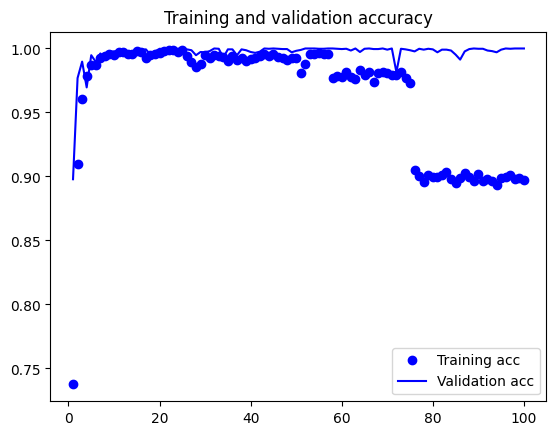

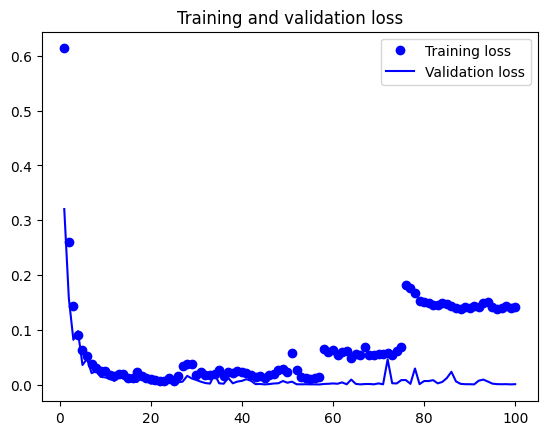

In [34]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
from tensorflow.keras.models import load_model
model = load_model('.\\checkpoint\\checkpoint099.ckpt')  
model.summary()

train_loss, train_acc = model.evaluate(train_features, train_labels)
print('train_acc=',train_acc)

validation_loss, validation_acc = model.evaluate(validation_features, validation_labels)
print('validation_acc=',validation_acc)

test_loss, test_acc = model.evaluate(test_features, test_labels)
print('test_acc=',test_acc)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4,194,561
Trainable params: 4,194,561
Non-trainable params: 0
_________________________________________________________________
274/274 [==============================] - 1s 3ms/step - loss: 4.4299e-05 - acc: 1.0000
train_acc= 1.0
137/137 [==============================] - 1s 4ms/step - loss: 4.6594e-04 - acc: 1.0000
validation_acc= 1.0
137/137 [==============================] - 0s 3ms/step - loss: 5.0176e-04 - acc: 1.0000
test_acc=

In [38]:
extra_test_dir='.\\dataset\\extra_test'
extra_test_features, extra_test_labels = extract_features(extra_test_dir, 7290)
extra_test_features = np.reshape(extra_test_features, (7290, 8 * 8 * 512))

extra_test_loss, extra_test_acc = model.evaluate(extra_test_features, extra_test_labels)
print('extra_test_acc=',extra_test_acc)

Found 7290 images belonging to 2 classes.
generator.class_indices= {'stable': 0, 'unstable': 1}
228/228 [==============================] - 1s 4ms/step - loss: 3.5349 - acc: 0.6733
extra_test_acc= 0.6732510328292847


In [18]:
endTime=time.time()
print('How many seconds:',(endTime-startTime))

How many seconds: 1098.2169251441956
